In [1]:
!pip install faiss-cpu sentence-transformers transformers rouge-score nltk

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

#Data Exploration, Cleaning and Preprocessing


In [2]:
#Importing Relevant Libraries
import pandas as pd
import os
import requests
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
import faiss
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import f1_score
import nltk
import warnings
warnings.filterwarnings("ignore")
nltk.download('punkt')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
#Reading Data
df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True)
df = df.sample(frac=1).reset_index(drop=True)
print(df.head())

                                            question  \
0                 What TV series are worth watching?   
1     Is there any prayer which God hasn’t answered?   
2  What is the most advanced invention in the world?   
3    What different styles of photography are there?   
4          Which is the best UberEATS clone in 2020?   

                                              answer  
0  There are many TV series that are considered "...  
1  Before we start ———————————————— I am a Muslim...  
2  Hey there! Thanks for asking such an interesti...  
3  There are various styles of photography. Some ...  
4  Hi,\n There are really lots of UberEats clone ...  


In [4]:
len(df)

56402

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56402 entries, 0 to 56401
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  56402 non-null  object
 1   answer    56402 non-null  object
dtypes: object(2)
memory usage: 881.4+ KB


In [6]:
df.describe()

,question,answer
count,56402,56402
unique,3234,54726
top,Would Hillary Clinton have made a better Presi...,No\n
freq,106,89


In [7]:
df.isnull().sum()

,0
question,0
answer,0


In [8]:
df['question'].value_counts()

,count
question,
Would Hillary Clinton have made a better President than Donald J Trump?,106
What is the most horrible thing you have seen while in a mental hospital?,104
"Having at 62, I have no pension. I haven’t payed enough in for old age pension and I am alone. What will I do? I work a few hours, have no savings, and live week to week. I live in Britain.",102
Do all UK people say they speak “English” and not “British English”?,102
What is on-page SEO?,102
What is the most foul smelling thing you found when cleaning out a room or closet in your house or garage?,102
Is investing in cryptocurrency still profitable?,102
Why would anyone need a gun with more than 10 rounds for concealed carry?,102
What are the best ways to invest money?,102


##Visualizations

In [9]:
# Calculating the length of each question and storing it in a new column 'question_length'
df['question_length'] = df['question'].apply(len)

# Calculating the length of each answer and storing it in a new column 'answer_length'
df['answer_length'] = df['answer'].apply(len)

# Calculating the word count of each question and storing it in a new column 'question_word_count'
df['question_word_count'] = df['question'].apply(lambda x: len(x.split()))

# Calculating the word count of each answer and storing it in a new column 'answer_word_count'
df['answer_word_count'] = df['answer'].apply(lambda x: len(x.split()))

# Calculating the number of common words between each question and answer and storing it in a new column 'common_words'
df['common_words'] = df.apply(lambda x: len(set(x['question'].split()).intersection(set(x['answer'].split()))), axis=1)


In [10]:
df.head()

,question,answer,question_length,answer_length,question_word_count,answer_word_count,common_words
0,What TV series are worth watching?,"There are many TV series that are considered ""...",34,3329,6,552,3
1,Is there any prayer which God hasn’t answered?,Before we start ———————————————— I am a Muslim...,46,4384,8,798,4
2,What is the most advanced invention in the world?,Hey there! Thanks for asking such an interesti...,49,1996,9,302,5
3,What different styles of photography are there?,There are various styles of photography. Some ...,47,306,7,38,4
4,Which is the best UberEATS clone in 2020?,"Hi,\n There are really lots of UberEats clone ...",41,758,8,109,5


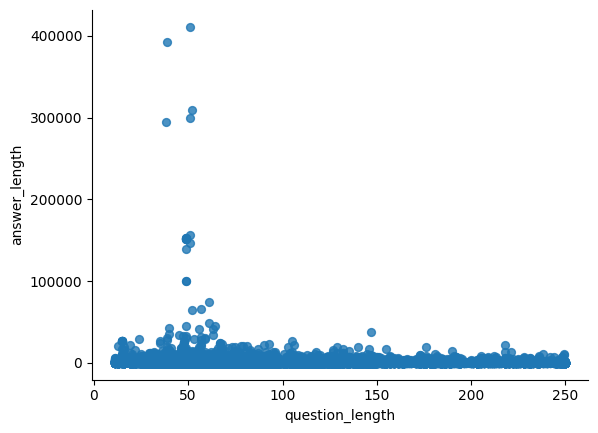

In [11]:
#Visualizing question_length vs answer_length
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='question_length', y='answer_length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

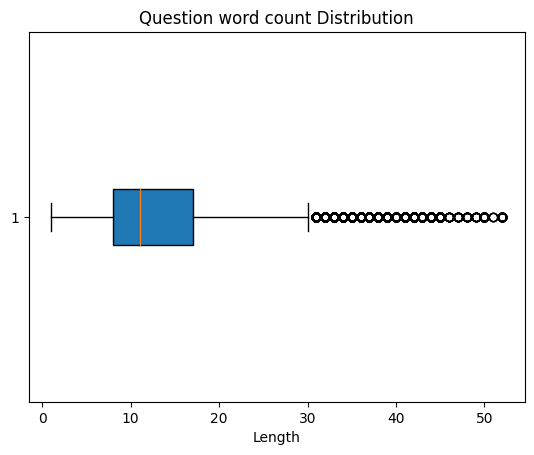

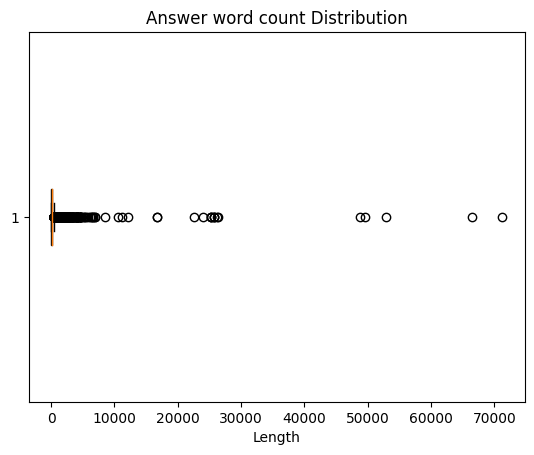

In [12]:
# Box plot for question length
plt.figure()
plt.boxplot(df['question_word_count'], vert=False, patch_artist=True)
plt.title('Question word count Distribution')
plt.xlabel('Length')
plt.show()

# Box plot for answer length
plt.figure()
plt.boxplot(df['answer_word_count'], vert=False, patch_artist=True)
plt.title('Answer word count Distribution')
plt.xlabel('Length')
plt.show()

# Calculating max and average lengths
max_question_length = df['question_word_count'].max()
avg_question_length = df['question_word_count'].mean()
max_answer_length = df['answer_word_count'].max()
avg_answer_length = df['answer_word_count'].mean()



In [13]:
#Calculating various statistics to removes answers that exceed a specified word count limit.
print("Max Question Word Count:", max_question_length)
print("Average Question Word Count:", avg_question_length)
print("Max Answer Word Count:", max_answer_length)
print("Average Answer Word Count:", avg_answer_length) #will truncate big answers since bert can't support this length

#Dropping answers with length over 10k
df = df[df['answer_word_count'] <= 10000]
print("Entries after removing outlier:", len(df))

Max Question Word Count: 52
Average Question Word Count: 14.110953512286798
Max Answer Word Count: 71232
Average Answer Word Count: 157.69128754299493
Entries after removing outlier: 56382


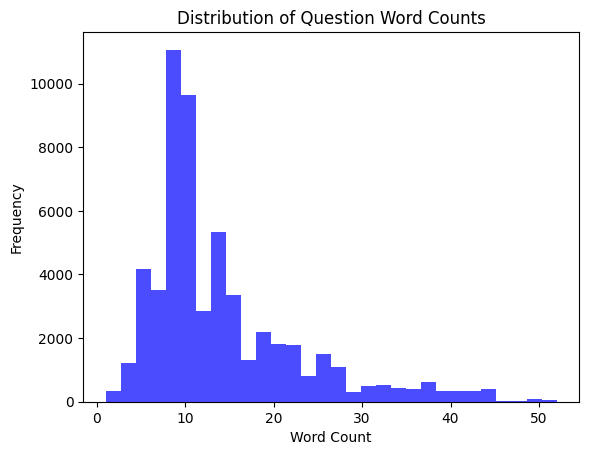

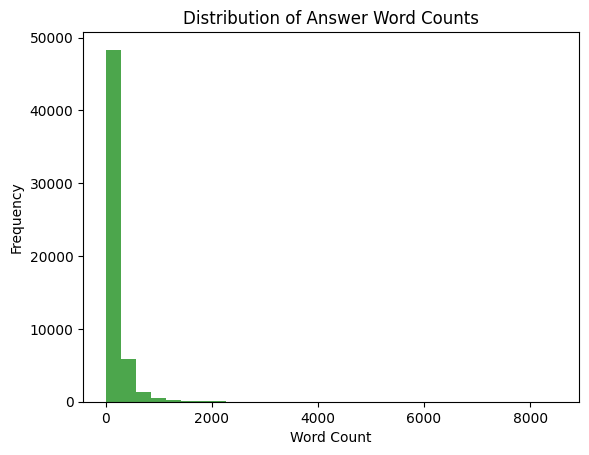

In [14]:
#Plotting the distribution of question word counts
df['question_word_count'].plot(kind='hist', bins=30, alpha=0.7, color='blue')
plt.title('Distribution of Question Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

#Plotting the distribution of answer word counts
df['answer_word_count'].plot(kind='hist', bins=30, alpha=0.7, color='green')
plt.title('Distribution of Answer Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

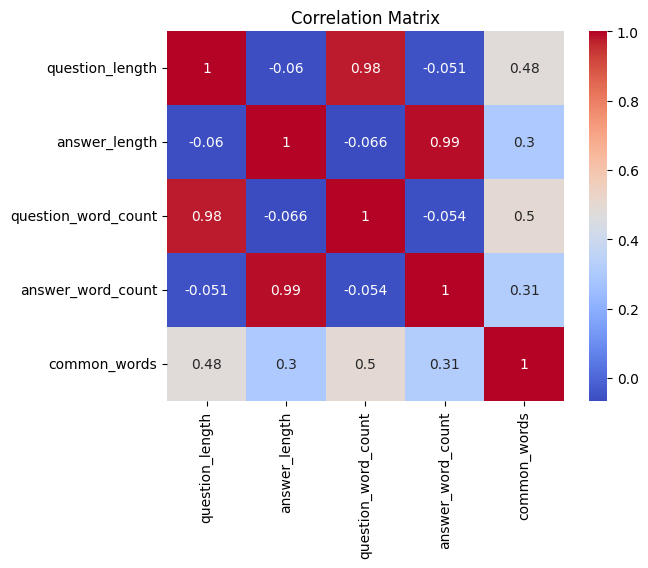

In [15]:
#Calculating the correlation matrix for new columns
import seaborn as sns
correlation_matrix = df[['question_length', 'answer_length', 'question_word_count', 'answer_word_count', 'common_words']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


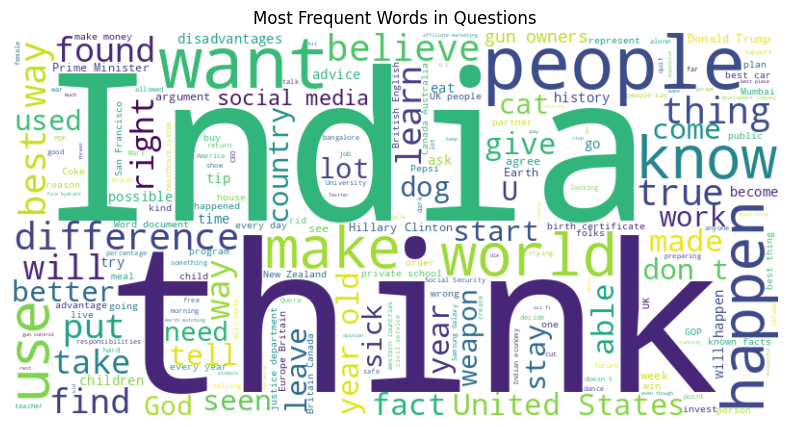

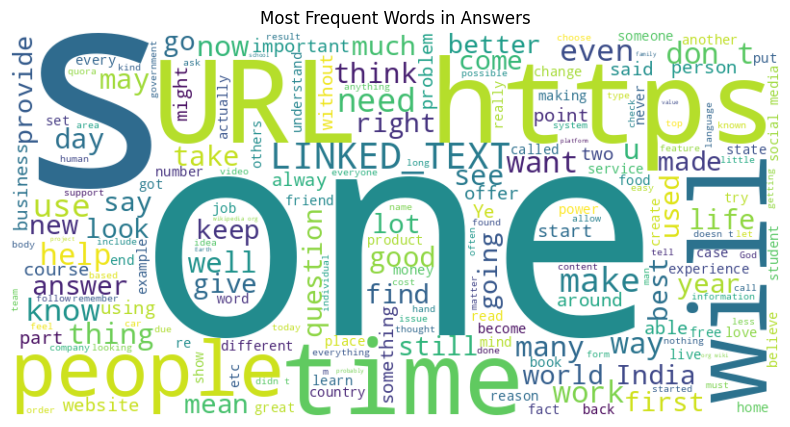

In [16]:
#Generate and display word clouds for the most frequent words in questions and answers
from wordcloud import WordCloud

question_text = ' '.join(df['question'].tolist())
answer_text = ' '.join(df['answer'].tolist())

question_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question_text)
answer_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(answer_text)

plt.figure(figsize=(10, 5))
plt.imshow(question_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Questions')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(answer_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Answers')
plt.show()


##Preprocessing

In [17]:
#Removing Duplicates
df.drop_duplicates(inplace=True)
#Removing Null Entries
df.dropna(inplace=True)

In [18]:
#Converting columns to Strings
df['question'] = df['question'].apply(str)
df['answer'] = df['answer'].apply(str)

In [19]:
df['reference_answer']=df['answer']

In [20]:
import nltk
from nltk.corpus import stopwords

#Downloading the list of stopwords
nltk.download('stopwords')

#Creating a set of English stopwords
stop_words = set(stopwords.words('english'))

#Function to remove stopwords from a given text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

#Applying the remove_stopwords function to the 'question' and 'answer' columns
df['question'] = df['question'].apply(remove_stopwords)
df['answer'] = df['answer'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
import re

# Function to remove special characters and emojis from a given text
def remove_special_chars(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply the remove_special_chars function to the 'question' and 'answer' columns
df['question'] = df['question'].apply(remove_special_chars)
df['answer'] = df['answer'].apply(remove_special_chars)

In [22]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

MAX_LEN = 512

def truncate_answer(row, max_len=MAX_LEN):
    question = row['question']
    answer = row['answer']

    if len(answer) <= max_len:
        return answer

    # Tokenize answer into sentences
    sentences = sent_tokenize(answer)

    # Check if adding sentences exceeds max_len
    truncated_answer = ""
    for sentence in sentences:
        if len(truncated_answer) + len(sentence) + 1 > max_len:
            break
        truncated_answer += sentence + " "
    return truncated_answer.strip()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
df['answer'] = df.apply(truncate_answer, axis=1)

In [24]:
df = df[(df['question'].str.strip() != '') & (df['answer'].str.strip() != '')]

#Model Selection and Evaluation




In [25]:
# Initializing sentence transformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_model = SentenceTransformer("average_word_embeddings_glove.6B.300d", device=device)

# Creating embeddings for the knowledge base
knowledge_base_vectors = embedding_model.encode(list(df.question), show_progress_bar=True).astype('float32')

# Initializing FAISS index
index = faiss.IndexFlatIP(knowledge_base_vectors.shape[1])
index.add(knowledge_base_vectors)

# Loading a question answering model
qa_model_name = "distilbert-base-uncased-distilled-squad"
qa_model = AutoModelForQuestionAnswering.from_pretrained(qa_model_name)
qa_tokenizer = AutoTokenizer.from_pretrained(qa_model_name)
qa_pipeline = pipeline('question-answering', model=qa_model, tokenizer=qa_tokenizer)

def search_vectors(index, query_vectors, k=5):
    D, I = index.search(query_vectors, k)
    return D, I

def get_relevant_documents(question, k=5):
    query_vector = embedding_model.encode([question]).astype('float32')
    distances, indices = search_vectors(index, query_vector, k)
    return df.iloc[indices[0]]

def generate_answer(question, context):
    result = qa_pipeline({'question': question, 'context': context})
    return result['answer']


modules.json:   0%|          | 0.00/248 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

(…)WordEmbeddings/wordembedding_config.json:   0%|          | 0.00/164 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)beddings/whitespacetokenizer_config.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1140 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [26]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Loading the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = GPT2LMHeadModel.from_pretrained('gpt2')

def get_natural_language_answer(question, answer):
    # Preparing the input text
    input_text = f"Rephrase the following answer naturally for the given question.\nQuestion: {question}\nAnswer: {answer}"
    input_ids = tokenizer.encode(input_text, return_tensors='pt', truncation=True, max_length=512)

    # Generating the output
    outputs = gpt_model.generate(input_ids, max_new_tokens=70, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
    natural_language_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    index_of_last_fullstop=len(natural_language_answer)-1
    if(natural_language_answer[-1]!='.'):
      for i in range(len(natural_language_answer)):
        if(natural_language_answer[i] == '.'):
          index_of_last_fullstop = i
    natural_language_answer = natural_language_answer[:index_of_last_fullstop+1]
    natural_language_answer=natural_language_answer.split()
    for i in range(len(natural_language_answer)):
        if(natural_language_answer[i] == 'Answer:'):
            natural_language_answer=natural_language_answer[i+1:]
            break
    natural_language_answer_str=''
    for i in natural_language_answer:
        natural_language_answer_str+=i+" "
    natural_language_answer_str=natural_language_answer_str.strip()

    return natural_language_answer_str

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [27]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Loading the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_model = GPT2LMHeadModel.from_pretrained('gpt2')

# Ensure pad_token_id is set to eos_token_id
tokenizer.pad_token = tokenizer.eos_token

def get_natural_language_answer(question, answer):
    # Preparing the input text
    input_text = f"Rephrase the following answer naturally for the given question.\nQuestion: {question}\nAnswer: {answer}"
    input_ids = tokenizer.encode(input_text, return_tensors='pt', truncation=True, max_length=512)

    # Creating attention mask
    attention_mask = input_ids.ne(tokenizer.pad_token_id).long()

    # Generating the output
    outputs = gpt_model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=70,
        num_beams=5,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    natural_language_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Finding the index of the last full stop to end the sentence properly
    index_of_last_fullstop = len(natural_language_answer) - 1
    if natural_language_answer[-1] != '.':
        for i in range(len(natural_language_answer)):
            if natural_language_answer[i] == '.':
                index_of_last_fullstop = i
    natural_language_answer = natural_language_answer[:index_of_last_fullstop + 1]

    # Removing the prefix "Answer:" from the output
    natural_language_answer = natural_language_answer.split()
    for i in range(len(natural_language_answer)):
        if natural_language_answer[i] == 'Answer:':
            natural_language_answer = natural_language_answer[i + 1:]
            break

    natural_language_answer_str = ' '.join(natural_language_answer).strip()

    return natural_language_answer_str


In [35]:
question = "what is the best way to earn money online?"

# Retrieving relevant documents
relevant_docs = get_relevant_documents(question)
context = " ".join(relevant_docs['answer'].tolist())
# Generating answer using the retrieved context
natural_language_answer = get_natural_language_answer(question, generate_answer(question, context))
print("Generated Answer: "+ natural_language_answer)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Answer: click best writing services LINKED_TEXT: http://en.wikipedia.org/wiki/Best_Writing_Services_for_Online_Profits The following is a list of some of the most popular online publishing services that you can use for earning money. You can click on any of them to find out more about them.


In [29]:
def evaluate_model(df):
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    bleu_scores = []
    f1_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for index, row in df.iterrows():
        question = row['question']
        reference_answer = row['reference_answer']

        relevant_docs = get_relevant_documents(question)
        context = " ".join(relevant_docs['answer'].tolist())

        # Generating answer using the retrieved context
        generated_answer = generate_answer(question, context)
        generated_answer = get_natural_language_answer(question, generated_answer)


        scores = rouge.score(reference_answer, generated_answer)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)


        reference_tokens = nltk.word_tokenize(reference_answer)
        generated_tokens = nltk.word_tokenize(generated_answer)
        bleu_score = sentence_bleu([reference_tokens], generated_tokens)
        bleu_scores.append(bleu_score)

        # Calculating F1 score (using token overlap)
        common_tokens = set(reference_tokens) & set(generated_tokens)
        if len(reference_tokens) == 0 or len(generated_tokens) == 0:
            f1 = 0
        else:
            precision = len(common_tokens) / len(generated_tokens)
            recall = len(common_tokens) / len(reference_tokens)
            if precision + recall == 0:
                f1 = 0
            else:
                f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)


    avg_bleu = np.mean(bleu_scores)
    avg_f1 = np.mean(f1_scores)
    avg_rouge1 = np.mean(rouge1_scores)
    avg_rouge2 = np.mean(rouge2_scores)
    avg_rougeL = np.mean(rougeL_scores)

    print(f"Average BLEU score: {avg_bleu}")
    print(f"Average F1 score: {avg_f1}")
    print(f"Average ROUGE-1 score: {avg_rouge1}")
    print(f"Average ROUGE-2 score: {avg_rouge2}")
    print(f"Average ROUGE-L score: {avg_rougeL}")
    return [avg_f1, avg_rouge1, avg_rouge2, avg_rougeL]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average BLEU score: 2.8614590023215236e-155
Average F1 score: 0.1504929974498075
Average ROUGE-1 score: 0.20430767135878533
Average ROUGE-2 score: 0.03248508778284914
Average ROUGE-L score: 0.12672626348287439


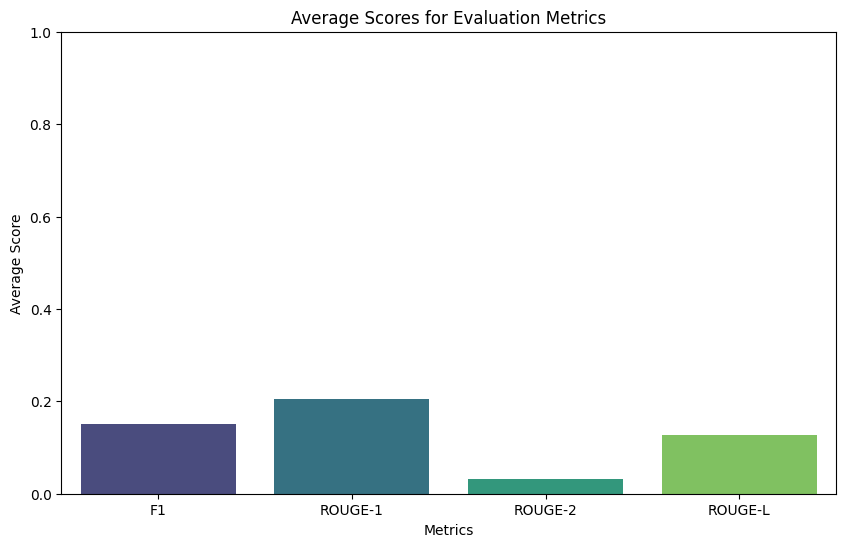

In [30]:
 # Plotting the results
metrics = ['F1', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
avg_scores =evaluate_model(df.head())

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=avg_scores, palette='viridis')
plt.title('Average Scores for Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Average Score')
plt.ylim(0, 1)
plt.show()

#Saving Relevant Information

In [31]:
import os
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
import faiss
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
import pickle

# Define paths for saving
pipeline_path = "qa_pipeline.pkl"
index_path = "faiss_index.bin"
knowledge_base_path = "knowledge_base_vectors.npy"
dataset_path = "question_answer_dataset.pkl"

# Save the QA pipeline
qa_pipeline_data = {
    'model': qa_model_name,
    'tokenizer': qa_model_name
}
with open(pipeline_path, 'wb') as f:
    pickle.dump(qa_pipeline_data, f)

# Save the FAISS index
faiss.write_index(index, index_path)

# Save the knowledge base vectors
np.save(knowledge_base_path, knowledge_base_vectors)

# Save the dataset
df.to_pickle(dataset_path)

print("All components saved successfully!")


All components saved successfully!
